In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:

tf.__version__

'2.0.0'

In [3]:
!nvidia-smi

Mon Oct 21 17:10:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    27W /  70W |    769MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
ds = tfds.load('oxford_iiit_pet', shuffle_files=True) 

In [5]:
def normalize_image(ele):
    image = ele['image']
    label = ele['label']
    paddings = tf.constant([[28,28], [28,28], [0,0]])
    image = tf.image.resize(image, size = [224,224])
    image = tf.pad(image, paddings, 'CONSTANT')
    image = tf.image.random_crop(image, size = [224,224,3])
    #image -= tf.reduce_mean(image) 
    image = (image - tf.reduce_min(image))/(tf.reduce_max(image)-tf.reduce_min(image))
    return image, label


ds_train = ds['train'].map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).repeat().shuffle(100).batch(16).prefetch(1)
ds_test = ds['test'].map(normalize_image , num_parallel_calls=tf.data.experimental.AUTOTUNE).repeat().shuffle(100).batch(16).prefetch(1)


In [6]:
print(ds['train'])

<_OptionsDataset shapes: {label: (), file_name: (), image: (None, None, 3), segmentation_mask: (None, None, 1)}, types: {label: tf.int64, file_name: tf.string, image: tf.uint8, segmentation_mask: tf.uint8}>


In [7]:
ds_test_iterator = iter(ds_test)

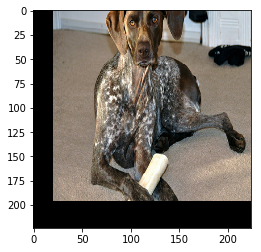

In [8]:
x,y = next(ds_test_iterator)
plt.imshow(x.numpy()[0])

In [19]:
def conv2D(x, filters, kernel=(3,3), strides=(1,1), activation=tf.nn.relu, use_bias=False):
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel, strides=strides, use_bias=use_bias, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation is not None:
        x = tf.keras.layers.Activation(activation)(x)
    return x

def block(x, trips=[64, 64, 256], first=False):
    if first:
        x = conv2D(x, trips[0], kernel=(1,1), strides=(2,2))
    else:
        x = conv2D(x, trips[0], kernel=(1,1))
        x = conv2D(x, trips[1], kernel=(3,3))
        x = conv2D(x, trips[2], kernel=(1,1))
    return x

def mini_block(x, trips = [16, 16] , first = False):
    if first:
        x = conv2D(x, trips[0], kernel =  (3,3), strides = (2,2))
    else:
        x = conv2D(x, trips[0], kernel = (3,3), strides = (1,1))
        x = conv2D(x, trips[1], kernel = (3,3), strides = (1,1))
    return x 

def SE_block(x, activations = tf.nn.relu, ratio = 16):
    depth = x.shape[3]
    prev = x
    prev = tf.keras.layers.GlobalAveragePooling2D()(prev)
    prev = tf.keras.layers.Dense(depth//ratio, activation= activations)(prev)
    prev = tf.keras.layers.Dense(depth, activation = tf.nn.sigmoid)(prev)
    x = x * tf.reshape(prev, [-1, 1, 1, depth])
    return x

def mesa_block(x, trips = [16,16], repeats = 36, downsample = True):
    prev = x
    for r in range(repeats):
        if r == 0 and downsample:
            prev = conv2D(prev, trips[1], kernel = (1,1), strides = (2,2), activation = None)
            x = mini_block(x, trips = trips, first = True)
    #  x = SE_block(x)
            x = tf.keras.layers.Add()([x,prev])
        elif r == 0 and not downsample:
            prev = x
            x = mini_block(x, trips = trips)
     # x = SE_block(x)
            x = tf.keras.layers.Add()([x,prev])
        else:
            prev = x
            x = mini_block(x, trips = trips)
      #x = SE_block(x)
            x = tf.keras.layers.Add()([x, prev])
    return x 

In [21]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = conv2D(inputs, 16, kernel=(3,3), strides=(1,1),)

### Block 1
x = mesa_block(x, trips=[16,16], repeats=18, downsample=False)

### Block 2
x = mesa_block(x, trips=[32, 32], repeats=18)

### Block 3

x = mesa_block(x, trips=[64,64], repeats=18)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(37, activation='softmax')(x) #logits 
resnet110 = tf.keras.Model(inputs, x)
resnet110.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 224, 224, 16) 432         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 224, 224, 16) 64          conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 224, 224, 16) 0           batch_normalization_13[0][0]     
______________________________________________________________________________________________

In [23]:
step = tf.Variable(0, trainable=False)
boundaries = [1, 82, 123]
values = [0.01, 0.1, 0.1/10, 0.1/100]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

learning_rate = learning_rate_fn(step)

In [24]:
resnet110.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet110.fit(ds_train, epochs=165, steps_per_epoch=230, validation_data=ds_test, validation_steps=10)

Train for 230 steps, validate for 10 steps
Epoch 1/165
230/230 [==============================] - 214s 932ms/step - loss: 4.0843 - accuracy: 0.0283 - val_loss: 2352.4543 - val_accuracy: 0.0250
Epoch 2/165
230/230 [==============================] - 196s 852ms/step - loss: 3.6252 - accuracy: 0.0302 - val_loss: 7.4780 - val_accuracy: 0.0312
Epoch 3/165
230/230 [==============================] - 196s 852ms/step - loss: 3.6184 - accuracy: 0.0315 - val_loss: 3.6207 - val_accuracy: 0.0250
Epoch 4/165
230/230 [==============================] - 196s 851ms/step - loss: 3.6168 - accuracy: 0.0326 - val_loss: 3.6420 - val_accuracy: 0.0312
Epoch 5/165
230/230 [==============================] - 196s 851ms/step - loss: 3.6062 - accuracy: 0.0340 - val_loss: 5.6172 - val_accuracy: 0.0188
Epoch 6/165
230/230 [==============================] - 195s 850ms/step - loss: 3.5965 - accuracy: 0.0370 - val_loss: 5.2186 - val_accuracy: 0.0188
Epoch 7/165
230/230 [==============================] - 196s 852ms/step -